In [193]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# for number crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns

/kaggle/input/online-retail-ii-uci/online_retail_II.csv


In [194]:
os.listdir('/kaggle/input/online-retail-ii-uci')

['online_retail_II.csv']

In [195]:
data = pd.read_csv('/kaggle/input/online-retail-ii-uci/online_retail_II.csv')

data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [196]:
data.columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


# Creating the necessary columns

In [197]:
# Making sure Date is in datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Total ammount column
data['TotalAmount'] = data['Price'] * data['Quantity']

data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


# Dropping null columns

In [198]:
# Validating null values
data.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
TotalAmount         0
dtype: int64

In [199]:
# Validating negative values
(data[['Price', 'Quantity', 'TotalAmount']] < 0).sum()

Price              5
Quantity       22950
TotalAmount    19498
dtype: int64

In [200]:
# Deleting all rows with null values
data = data.dropna(subset = ['Customer ID'])

# Eliminating rows with negative quantities

# Note: don't eliminate this data, TO BE DETERMINED

data = data[data['Quantity'] >= 0]

data = data[data['Price'] >= 0]

In [201]:
# Validating null values again
data.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
TotalAmount    0
dtype: int64

In [202]:
# Validating negative values again
(data[['Price', 'Quantity', 'TotalAmount']] < 0).sum()

Price          0
Quantity       0
TotalAmount    0
dtype: int64

# Data Cleaning

<function matplotlib.pyplot.show(close=None, block=None)>

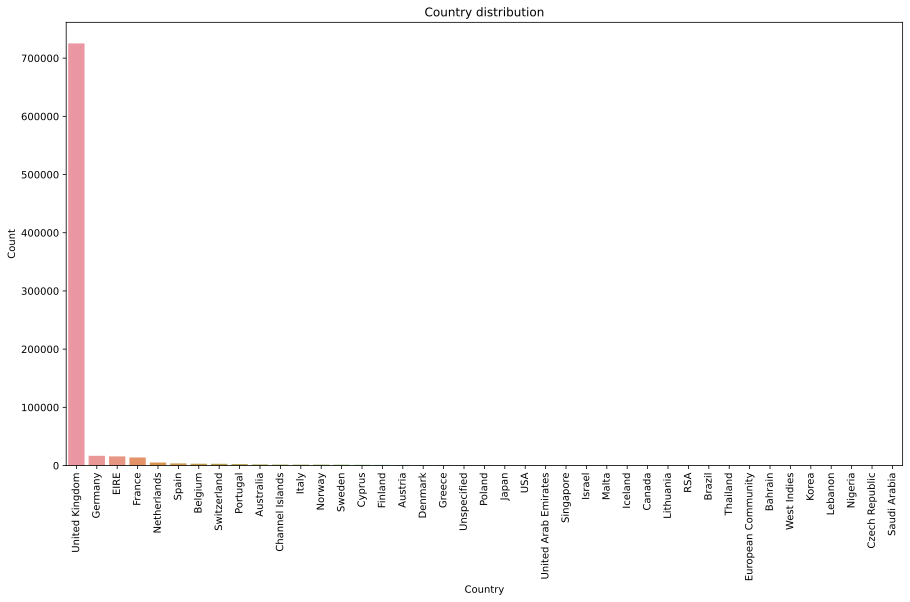

In [203]:
# Payment method distribution
plt.figure(figsize=(15, 8))
sns.countplot(data= data, x='Country', order=data['Country'].value_counts().index)
plt.title('Country distribution')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation= 90)
plt.show

In [204]:
# We'll only work with transactions from the UK

# Keeping only transactions made in the UK
data = data[data['Country'] == 'United Kingdom']

In [205]:
print(data['Country'].describe())

count             725296
unique                 1
top       United Kingdom
freq              725296
Name: Country, dtype: object


# Price, Quantity and Total Amount distributions

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Quantity', ylabel='Percent'>

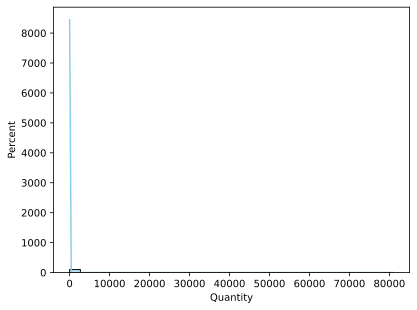

In [206]:
sns.histplot(data['Quantity'],bins=30, kde=True, color="skyblue", stat="percent")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Price', ylabel='Percent'>

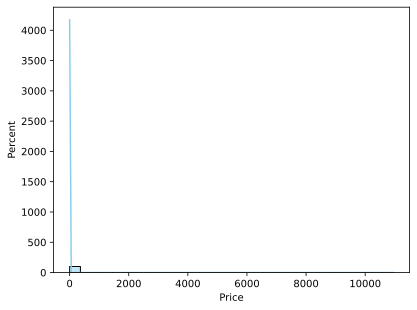

In [207]:
sns.histplot(data['Price'],bins=30, kde=True, color="skyblue", stat="percent")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='TotalAmount', ylabel='Percent'>

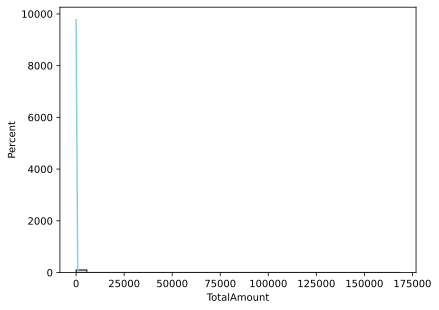

In [208]:
sns.histplot(data['TotalAmount'],bins=30, kde=True, color="skyblue", stat="percent")

In [209]:
# Distribution for Quantity
print(data['Quantity'].describe())

count    725296.000000
mean         12.021055
std         141.560253
min           1.000000
25%           2.000000
50%           4.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64


In [210]:
# Distribution for Price
print(data['Price'].describe())

count    725296.000000
mean          3.056583
std          25.164725
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max       10953.500000
Name: Price, dtype: float64


In [211]:
# Distribution for Total Amount
print(data['TotalAmount'].describe())

count    725296.000000
mean         20.299502
std         233.938767
min           0.000000
25%           4.200000
50%          10.200000
75%          17.700000
max      168469.600000
Name: TotalAmount, dtype: float64


In [212]:
#Dropping the outliers from data and saving them on other dataset!
# dataOutliersQuantity = data[data['Quantity'] > data['Quantity'].quantile(0.97)]
# dataOutliersPrice = data[data['Price'] > data['Price'].quantile(0.98)]
# dataOutliersTotalAmount = data[data['TotalAmount'] > data['TotalAmount'].quantile(0.98)]

# data = data[data['Quantity'] < data['Quantity'].quantile(0.97)]
# data = data[data['Price'] < data['Price'].quantile(0.98)]
# data = data[data['TotalAmount'] < data['TotalAmount'].quantile(0.98)]

# Podemos hacer un estudio aparte de los outliers como explica el profe Juan Trabucco para no ignorar esta data!
# Segmentar los datos que voy a modelar con mi NN y los que no (estos outliers).
# 
# Punto importante: Toda la data esta distribuida en Gamma.
# 
# Sacarle el log a cantidad y precio para ver la verdadera distribucion centrada y ver si podemos usar la data con esta 
# transformacion enves de eliminarla.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Quantity', ylabel='Percent'>

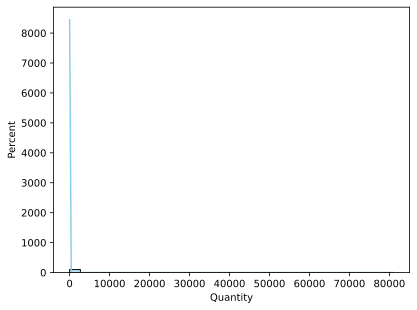

In [213]:
sns.histplot(data['Quantity'],bins=30, kde=True, color="skyblue", stat="percent")

In [214]:
# Distribution for Quantity
print(data['Quantity'].describe())

count    725296.000000
mean         12.021055
std         141.560253
min           1.000000
25%           2.000000
50%           4.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Price', ylabel='Percent'>

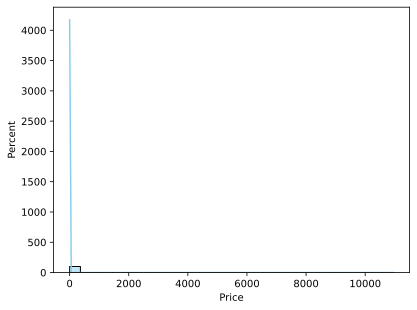

In [215]:
sns.histplot(data['Price'],bins=30, kde=True, color="skyblue", stat="percent")

In [216]:
# Distribution for Quantity
print(data['Price'].describe())

count    725296.000000
mean          3.056583
std          25.164725
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max       10953.500000
Name: Price, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='TotalAmount', ylabel='Percent'>

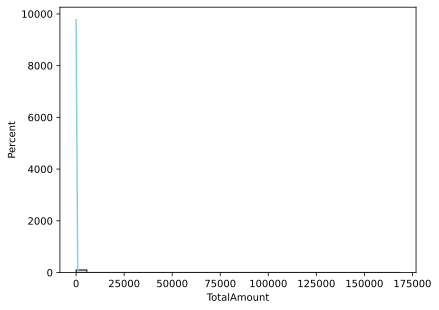

In [217]:
sns.histplot(data['TotalAmount'],bins=30, kde=True, color="skyblue", stat="percent")

In [218]:
# Distribution for Quantity
print(data['TotalAmount'].describe())

count    725296.000000
mean         20.299502
std         233.938767
min           0.000000
25%           4.200000
50%          10.200000
75%          17.700000
max      168469.600000
Name: TotalAmount, dtype: float64


# Creating the Customer Dataset

In [219]:
# Calculating the "present day" for metrics like Recency
presentDay = data['InvoiceDate'].max()

# Calculate date metrics
firstPurchase = data.groupby('Customer ID')['InvoiceDate'].min()
lastPurchase = data.groupby('Customer ID')['InvoiceDate'].max()

# Calculate customer lifespan metrics
# We don't want 0 in active days, as it's false. First day counts as 1.
activeDays = (lastPurchase - firstPurchase).dt.days + 1
recency = (presentDay - lastPurchase).dt.days
activeYears = activeDays / 365.25
activeMonths = activeDays / 30.44

customerData = data.groupby('Customer ID').agg(
    # CLV
    Monetary = ('TotalAmount', 'sum'),
    
    # Average item Price
    AvgPrice = ('Price', 'mean'), 

    # Average Total Amount per transaction
    AvgTotalAmount = ('TotalAmount', 'mean'), 

    # Average Quantity purchased per item
    AvgQuantity = ('Quantity', 'mean'), 
    
    # How many unique products bought
    ProductDiversity = ('StockCode', 'nunique')
)

# Number of *invoices* per customer (true purchase frequency)
purchaseFrequency = data.groupby('Customer ID')['InvoiceDate'].nunique()

monetary = data.groupby('Customer ID')['TotalAmount'].sum()

# Calculate averages for more metrics
AvgYearlyPurchase = monetary / activeYears
AvgMonthlyPurchase = monetary / activeMonths

# Frequency
customerData['Frequency'] = purchaseFrequency

# Recency (Days since last purchase) merge
customerData['Recency'] = recency

# Active days
customerData['ActiveDays'] = activeDays

customerData.head(10)

,Monetary,AvgPrice,AvgTotalAmount,AvgQuantity,ProductDiversity,Frequency,Recency,ActiveDays
Customer ID,,,,,,,,
12346.0,77556.46,6.100000,2281.072353,2184.852941,27,12,325,401
12608.0,415.79,1.627500,25.986875,20.187500,16,1,404,1
12745.0,723.85,3.090000,32.902273,21.227273,20,2,486,88
12746.0,254.55,3.476471,14.973529,5.705882,17,1,540,1
12747.0,9276.54,4.341634,36.095486,10.731518,85,26,1,731
12748.0,56599.39,2.980941,7.828408,5.409405,2287,338,0,735
12749.0,6897.36,5.479083,20.406391,6.982249,260,9,3,518
12777.0,519.45,3.200385,19.978846,17.615385,26,1,457,1
12819.0,540.52,3.334211,28.448421,18.105263,19,1,457,1


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Monetary', ylabel='Percent'>

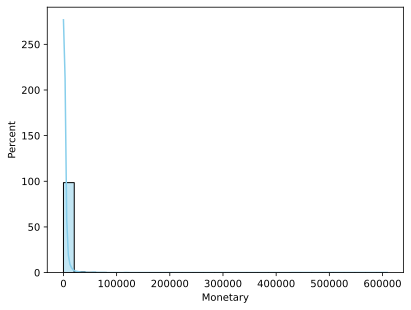

In [220]:
sns.histplot(customerData['Monetary'],bins=30, kde=True, color="skyblue", stat="percent")

In [221]:
print(customerData['Monetary'].describe())

count      5353.000000
mean       2750.447883
std       12077.255964
min           0.000000
25%         335.520000
50%         848.710000
75%        2212.280000
max      608821.650000
Name: Monetary, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Frequency', ylabel='Percent'>

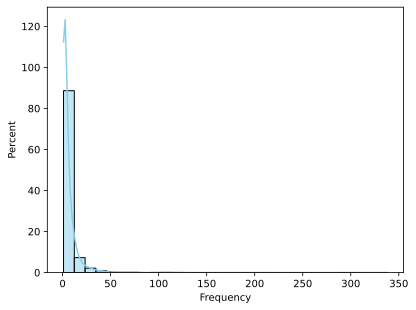

In [222]:
sns.histplot(customerData['Frequency'],bins=30, kde=True, color="skyblue", stat="percent")

In [223]:
print(customerData['Frequency'].describe())

count    5353.000000
mean        6.245470
std        11.902062
min         1.000000
25%         1.000000
50%         3.000000
75%         7.000000
max       338.000000
Name: Frequency, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Recency', ylabel='Percent'>

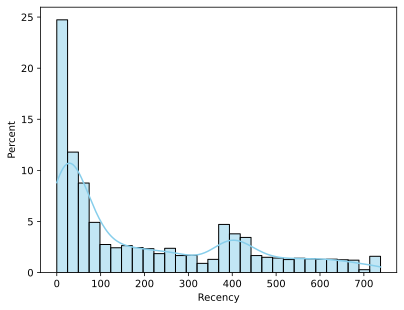

In [224]:
sns.histplot(customerData['Recency'],bins=30, kde=True, color="skyblue", stat="percent")

In [225]:
print(customerData['Recency'].describe())

count    5353.000000
mean      202.138240
std       210.106131
min         0.000000
25%        25.000000
50%        98.000000
75%       381.000000
max       738.000000
Name: Recency, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='AvgTotalAmount', ylabel='Percent'>

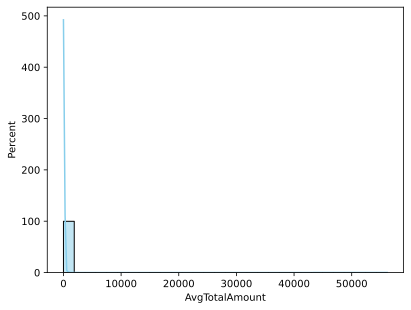

In [226]:
sns.histplot(customerData['AvgTotalAmount'],bins=30, kde=True, color="skyblue", stat="percent")

In [227]:
print(customerData['AvgTotalAmount'].describe())

count     5353.000000
mean        47.984914
std        811.488215
min          0.000000
25%         10.711622
50%         16.981774
75%         23.656500
max      56157.500000
Name: AvgTotalAmount, dtype: float64


In [228]:
#Dropping the outliers from data and saving them on other dataset!
customerDataOutliersMonetary= customerData[customerData['Monetary'] > customerData['Monetary'].quantile(0.97)]
customerDataOutliersFrequency = customerData[customerData['Frequency'] > customerData['Frequency'].quantile(0.97)]
customerDataOutliersRecency = customerData[customerData['Recency'] > customerData['Recency'].quantile(0.99)]
customerDataOutliersAvgTotalAmount = customerData[customerData['AvgTotalAmount'] > customerData['AvgTotalAmount'].quantile(0.97)]

customerData = customerData[customerData['Monetary'] < customerData['Monetary'].quantile(0.97)]
customerData = customerData[customerData['Frequency'] < customerData['Frequency'].quantile(0.97)]
customerData = customerData[customerData['Recency'] < customerData['Recency'].quantile(0.99)]
customerData = customerData[customerData['AvgTotalAmount'] < customerData['AvgTotalAmount'].quantile(0.97)]

Quedamos con el 90% de la data original despues de limpiar los outliers!

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Monetary', ylabel='Percent'>

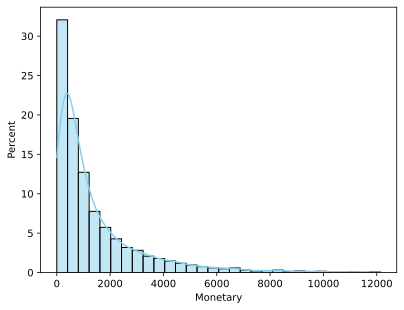

In [229]:
sns.histplot(customerData['Monetary'],bins=30, kde=True, color="skyblue", stat="percent")

In [230]:
print(customerData['Monetary'].describe())

count     4818.000000
mean      1415.640951
std       1726.822804
min          0.000000
25%        321.112500
50%        776.210000
75%       1804.735000
max      12142.570000
Name: Monetary, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Frequency', ylabel='Percent'>

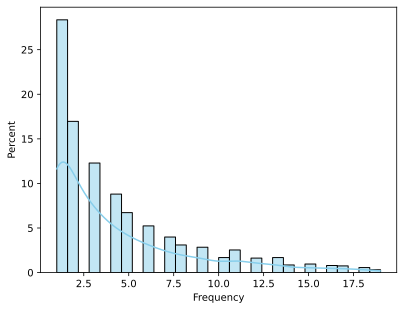

In [231]:
sns.histplot(customerData['Frequency'],bins=30, kde=True, color="skyblue", stat="percent")

In [232]:
print(customerData['Frequency'].describe())

count    4818.000000
mean        4.310710
std         3.943073
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        19.000000
Name: Frequency, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Recency', ylabel='Percent'>

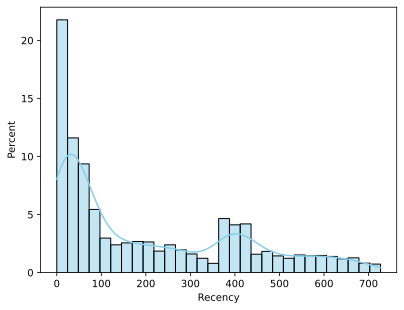

In [233]:
sns.histplot(customerData['Recency'],bins=30, kde=True, color="skyblue", stat="percent")

In [234]:
print(customerData['Recency'].describe())

count    4818.000000
mean      206.382524
std       205.385204
min         0.000000
25%        30.000000
50%       112.000000
75%       383.000000
max       727.000000
Name: Recency, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='AvgTotalAmount', ylabel='Percent'>

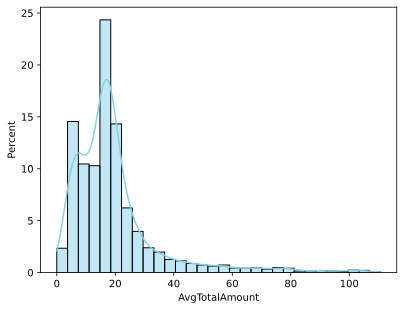

In [235]:
sns.histplot(customerData['AvgTotalAmount'],bins=30, kde=True, color="skyblue", stat="percent")

In [236]:
print(customerData['AvgTotalAmount'].describe())

count    4818.000000
mean       19.563536
std        15.669445
min         0.000000
25%        10.191462
50%        16.652655
75%        21.552879
max       110.688111
Name: AvgTotalAmount, dtype: float64
